# Imports

In [1]:
import os, random, cv2, gc, torch, timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Hyperparameter and Environment Configuration

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/kaggle/input/processed-dr-balanced" 
BATCH_SIZE = 16
ACCUM_STEPS = 4 
EPOCHS = 50
LR = 2e-4
MIN_LR = 1e-6
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.01
PATIENCE = 6


# Data Preparation

In [3]:
# LOADING DATA
all_paths, all_labels = [], []
for label in ['0', '1', '2', '3', '4']:
    folder = os.path.join(DATA_DIR, label)
    if not os.path.exists(folder): continue
    imgs = [os.path.join(folder, f) for f in os.listdir(folder)]
    all_paths.extend(imgs)
    all_labels.extend([int(label)] * len(imgs))

X_train,X_test, y_train,y_test = train_test_split(
    all_paths, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)


class BalancedDRDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths, self.labels, self.transform = paths, labels, transform
    
    def __len__(self): return len(self.paths)
    
    def __getitem__(self, idx):
        # Image is already 640px and Ben Graham filtered!
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.labels[idx])
        

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use shuffle=True instead of a Sampler since the data is already balanced on disk
train_loader = DataLoader(BalancedDRDataset(X_train, y_train, train_transform), 
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(BalancedDRDataset(X_test, y_test, val_transform), 
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Model architecture

In [4]:
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomHighResDR(nn.Module):
#     def __init__(self):
#         super(CustomHighResDR, self).__init__()
#         # Deeper architecture to handle 640px and learn from scratch
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3), # 320x320
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2, padding=1),                # 160x160

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),                                  # 80x80

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),                                  # 40x40

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.AdaptiveAvgPool2d(1)                              # 1x1
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 5)
#         )

#         # HE INITIALIZATION: Essential for scratch models to 'wake up'
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         return self.classifier(x)

# # Replace the timm line with this:
# model = CustomHighResDR().to(DEVICE)

In [5]:


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class CustomModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),  # 640 → 320
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )   # 320 × 320

        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),  # 320 → 160
            ResidualBlock(128, 128)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2), # 160 → 80
            ResidualBlock(256, 256)
        )

        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2), # 80 → 40
            ResidualBlock(512, 512)
        )

        # Classifier 
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


model = CustomModel().to(DEVICE)
print("Model fixed! Ready for training.")

Model fixed! Ready for training.


# Model training

In [6]:
# OPTIMIZER & SCHEDULER 
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS + 5, eta_min=MIN_LR)
scaler = torch.amp.GradScaler()

history = []
early_stop_counter = 0  # Initialize counter
best_kappa = -1.0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(pbar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / ACCUM_STEPS
            
        scaler.scale(loss).backward()
        
        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        running_loss += loss.item() * ACCUM_STEPS
        correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': f"{running_loss/(i+1):.4f}", 'acc': f"{correct/total:.4f}"})

    # VALIDATION 
    model.eval()
    all_preds, all_labs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(DEVICE))
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labs.extend(labels.cpu().numpy())

    val_kappa = cohen_kappa_score(all_labs, all_preds, weights='quadratic')
    epoch_acc = correct/total
    epoch_loss = running_loss/len(train_loader)
    
    history.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_acc': epoch_acc,
        'val_kappa': val_kappa
    })
    
    print(f"Epoch {epoch+1}: Loss {epoch_loss:.4f} | Acc {epoch_acc:.4f} | Kappa {val_kappa:.4f}")
    
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), "custom_model.pth")
        print("New Best Kappa! Saved Weights.")
        early_stop_counter = 0  # Reset
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{PATIENCE}")

    if early_stop_counter >= PATIENCE:
        print(f"Early Stopping triggered at Epoch {epoch+1}")
        break

    scheduler.step()
    print(f"Current LR: {scheduler.get_last_lr()[0]:.2e}")
    gc.collect()
    torch.cuda.empty_cache()

Epoch 1/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.4026, acc=0.3655]


Epoch 1: Loss 1.4026 | Acc 0.3655 | Kappa 0.4608
New Best Kappa! Saved Weights.
Current LR: 2.00e-04


Epoch 2/50: 100%|██████████| 983/983 [11:55<00:00,  1.37it/s, loss=1.2817, acc=0.4371]


Epoch 2: Loss 1.2817 | Acc 0.4371 | Kappa 0.5910
New Best Kappa! Saved Weights.
Current LR: 1.99e-04


Epoch 3/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.2188, acc=0.4661]


Epoch 3: Loss 1.2188 | Acc 0.4661 | Kappa 0.6448
New Best Kappa! Saved Weights.
Current LR: 1.99e-04


Epoch 4/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.1746, acc=0.4833]


Epoch 4: Loss 1.1746 | Acc 0.4833 | Kappa 0.6518
New Best Kappa! Saved Weights.
Current LR: 1.97e-04


Epoch 5/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.1333, acc=0.5089]


Epoch 5: Loss 1.1333 | Acc 0.5089 | Kappa 0.6772
New Best Kappa! Saved Weights.
Current LR: 1.96e-04


Epoch 6/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=1.0888, acc=0.5342]


Epoch 6: Loss 1.0888 | Acc 0.5342 | Kappa 0.6990
New Best Kappa! Saved Weights.
Current LR: 1.94e-04


Epoch 7/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=1.0694, acc=0.5463]


Epoch 7: Loss 1.0694 | Acc 0.5463 | Kappa 0.6738
No improvement. Patience: 1/6
Current LR: 1.92e-04


Epoch 8/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=1.0463, acc=0.5557]


Epoch 8: Loss 1.0463 | Acc 0.5557 | Kappa 0.6915
No improvement. Patience: 2/6
Current LR: 1.90e-04


Epoch 9/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.0443, acc=0.5599]


Epoch 9: Loss 1.0443 | Acc 0.5599 | Kappa 0.7424
New Best Kappa! Saved Weights.
Current LR: 1.87e-04


Epoch 10/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=1.0183, acc=0.5748]


Epoch 10: Loss 1.0183 | Acc 0.5748 | Kappa 0.7157
No improvement. Patience: 1/6
Current LR: 1.84e-04


Epoch 11/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9931, acc=0.5898]


Epoch 11: Loss 0.9931 | Acc 0.5898 | Kappa 0.7541
New Best Kappa! Saved Weights.
Current LR: 1.81e-04


Epoch 12/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9858, acc=0.5915]


Epoch 12: Loss 0.9858 | Acc 0.5915 | Kappa 0.7273
No improvement. Patience: 1/6
Current LR: 1.78e-04


Epoch 13/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9723, acc=0.5985]


Epoch 13: Loss 0.9723 | Acc 0.5985 | Kappa 0.7445
No improvement. Patience: 2/6
Current LR: 1.74e-04


Epoch 14/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9566, acc=0.6042]


Epoch 14: Loss 0.9566 | Acc 0.6042 | Kappa 0.7146
No improvement. Patience: 3/6
Current LR: 1.70e-04


Epoch 15/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.9449, acc=0.6153]


Epoch 15: Loss 0.9449 | Acc 0.6153 | Kappa 0.7666
New Best Kappa! Saved Weights.
Current LR: 1.66e-04


Epoch 16/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.9307, acc=0.6169]


Epoch 16: Loss 0.9307 | Acc 0.6169 | Kappa 0.7560
No improvement. Patience: 1/6
Current LR: 1.61e-04


Epoch 17/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9340, acc=0.6212]


Epoch 17: Loss 0.9340 | Acc 0.6212 | Kappa 0.7649
No improvement. Patience: 2/6
Current LR: 1.57e-04


Epoch 18/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.9228, acc=0.6231]


Epoch 18: Loss 0.9228 | Acc 0.6231 | Kappa 0.7440
No improvement. Patience: 3/6
Current LR: 1.52e-04


Epoch 19/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.9125, acc=0.6277]


Epoch 19: Loss 0.9125 | Acc 0.6277 | Kappa 0.7661
No improvement. Patience: 4/6
Current LR: 1.47e-04


Epoch 20/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.9022, acc=0.6317]


Epoch 20: Loss 0.9022 | Acc 0.6317 | Kappa 0.7305
No improvement. Patience: 5/6
Current LR: 1.42e-04


Epoch 21/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.8947, acc=0.6341]


Epoch 21: Loss 0.8947 | Acc 0.6341 | Kappa 0.7712
New Best Kappa! Saved Weights.
Current LR: 1.37e-04


Epoch 22/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.8915, acc=0.6377]


Epoch 22: Loss 0.8915 | Acc 0.6377 | Kappa 0.7639
No improvement. Patience: 1/6
Current LR: 1.31e-04


Epoch 23/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.8849, acc=0.6457]


Epoch 23: Loss 0.8849 | Acc 0.6457 | Kappa 0.7614
No improvement. Patience: 2/6
Current LR: 1.26e-04


Epoch 24/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.8701, acc=0.6510]


Epoch 24: Loss 0.8701 | Acc 0.6510 | Kappa 0.7807
New Best Kappa! Saved Weights.
Current LR: 1.20e-04


Epoch 25/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.8591, acc=0.6539]


Epoch 25: Loss 0.8591 | Acc 0.6539 | Kappa 0.7730
No improvement. Patience: 1/6
Current LR: 1.15e-04


Epoch 26/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.8508, acc=0.6617]


Epoch 26: Loss 0.8508 | Acc 0.6617 | Kappa 0.7875
New Best Kappa! Saved Weights.
Current LR: 1.09e-04


Epoch 27/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.8448, acc=0.6614]


Epoch 27: Loss 0.8448 | Acc 0.6614 | Kappa 0.7756
No improvement. Patience: 1/6
Current LR: 1.03e-04


Epoch 28/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.8342, acc=0.6666]


Epoch 28: Loss 0.8342 | Acc 0.6666 | Kappa 0.7715
No improvement. Patience: 2/6
Current LR: 9.77e-05


Epoch 29/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.8264, acc=0.6675]


Epoch 29: Loss 0.8264 | Acc 0.6675 | Kappa 0.7881
New Best Kappa! Saved Weights.
Current LR: 9.20e-05


Epoch 30/50: 100%|██████████| 983/983 [12:00<00:00,  1.36it/s, loss=0.8222, acc=0.6708]


Epoch 30: Loss 0.8222 | Acc 0.6708 | Kappa 0.7805
No improvement. Patience: 1/6
Current LR: 8.63e-05


Epoch 31/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.8098, acc=0.6818]


Epoch 31: Loss 0.8098 | Acc 0.6818 | Kappa 0.7788
No improvement. Patience: 2/6
Current LR: 8.07e-05


Epoch 32/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.8009, acc=0.6803]


Epoch 32: Loss 0.8009 | Acc 0.6803 | Kappa 0.7564
No improvement. Patience: 3/6
Current LR: 7.52e-05


Epoch 33/50: 100%|██████████| 983/983 [11:56<00:00,  1.37it/s, loss=0.7955, acc=0.6862]


Epoch 33: Loss 0.7955 | Acc 0.6862 | Kappa 0.7839
No improvement. Patience: 4/6
Current LR: 6.98e-05


Epoch 34/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.7851, acc=0.6949]


Epoch 34: Loss 0.7851 | Acc 0.6949 | Kappa 0.7923
New Best Kappa! Saved Weights.
Current LR: 6.44e-05


Epoch 35/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.7761, acc=0.6955]


Epoch 35: Loss 0.7761 | Acc 0.6955 | Kappa 0.7644
No improvement. Patience: 1/6
Current LR: 5.92e-05


Epoch 36/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.7686, acc=0.6974]


Epoch 36: Loss 0.7686 | Acc 0.6974 | Kappa 0.7944
New Best Kappa! Saved Weights.
Current LR: 5.41e-05


Epoch 37/50: 100%|██████████| 983/983 [11:57<00:00,  1.37it/s, loss=0.7545, acc=0.7042]


Epoch 37: Loss 0.7545 | Acc 0.7042 | Kappa 0.7846
No improvement. Patience: 1/6
Current LR: 4.91e-05


Epoch 38/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.7480, acc=0.7098]


Epoch 38: Loss 0.7480 | Acc 0.7098 | Kappa 0.7914
No improvement. Patience: 2/6
Current LR: 4.43e-05


Epoch 39/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.7385, acc=0.7126]


Epoch 39: Loss 0.7385 | Acc 0.7126 | Kappa 0.7782
No improvement. Patience: 3/6
Current LR: 3.97e-05


Epoch 40/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.7376, acc=0.7134]


Epoch 40: Loss 0.7376 | Acc 0.7134 | Kappa 0.7938
No improvement. Patience: 4/6
Current LR: 3.53e-05


Epoch 41/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.7233, acc=0.7181]


Epoch 41: Loss 0.7233 | Acc 0.7181 | Kappa 0.7995
New Best Kappa! Saved Weights.
Current LR: 3.12e-05


Epoch 42/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.7135, acc=0.7225]


Epoch 42: Loss 0.7135 | Acc 0.7225 | Kappa 0.8020
New Best Kappa! Saved Weights.
Current LR: 2.72e-05


Epoch 43/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.7097, acc=0.7261]


Epoch 43: Loss 0.7097 | Acc 0.7261 | Kappa 0.8015
No improvement. Patience: 1/6
Current LR: 2.35e-05


Epoch 44/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.7030, acc=0.7267]


Epoch 44: Loss 0.7030 | Acc 0.7267 | Kappa 0.7931
No improvement. Patience: 2/6
Current LR: 2.00e-05


Epoch 45/50: 100%|██████████| 983/983 [11:58<00:00,  1.37it/s, loss=0.6931, acc=0.7364]


Epoch 45: Loss 0.6931 | Acc 0.7364 | Kappa 0.8114
New Best Kappa! Saved Weights.
Current LR: 1.68e-05


Epoch 46/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.6893, acc=0.7362]


Epoch 46: Loss 0.6893 | Acc 0.7362 | Kappa 0.8026
No improvement. Patience: 1/6
Current LR: 1.39e-05


Epoch 47/50: 100%|██████████| 983/983 [11:59<00:00,  1.37it/s, loss=0.6797, acc=0.7400]


Epoch 47: Loss 0.6797 | Acc 0.7400 | Kappa 0.8050
No improvement. Patience: 2/6
Current LR: 1.12e-05


Epoch 48/50: 100%|██████████| 983/983 [12:00<00:00,  1.37it/s, loss=0.6758, acc=0.7379]


Epoch 48: Loss 0.6758 | Acc 0.7379 | Kappa 0.8094
No improvement. Patience: 3/6
Current LR: 8.85e-06


Epoch 49/50: 100%|██████████| 983/983 [12:02<00:00,  1.36it/s, loss=0.6699, acc=0.7452]


Epoch 49: Loss 0.6699 | Acc 0.7452 | Kappa 0.8082
No improvement. Patience: 4/6
Current LR: 6.79e-06


Epoch 50/50: 100%|██████████| 983/983 [12:02<00:00,  1.36it/s, loss=0.6647, acc=0.7482]


Epoch 50: Loss 0.6647 | Acc 0.7482 | Kappa 0.8060
No improvement. Patience: 5/6
Current LR: 5.03e-06


# Model Evaluation

---

Final Evaluation: 100%|██████████| 174/174 [00:36<00:00,  4.77it/s]



Detailed Classification Report:
                precision    recall  f1-score   support

        No DR       0.68      0.76      0.72       750
         Mild       0.58      0.44      0.50       525
     Moderate       0.62      0.72      0.67       750
       Severe       0.73      0.64      0.69       375
Proliferative       0.85      0.74      0.79       375

     accuracy                           0.67      2775
    macro avg       0.69      0.66      0.67      2775
 weighted avg       0.67      0.67      0.67      2775



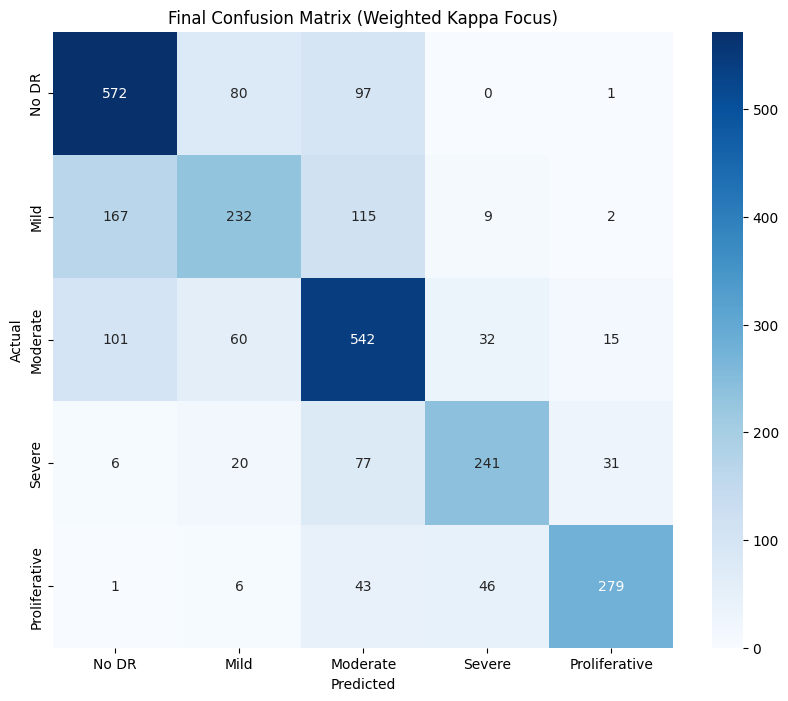

In [7]:

def final_evaluation(model, val_loader, device):
    model.load_state_dict(torch.load("custom_model.pth"))
    model.eval()
    
    all_preds, all_labs = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Final Evaluation"):
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(device))
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labs.extend(labels.numpy())
    
    # 1. Classification Report (Precision, Recall, F1)
    classes = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
    report = classification_report(all_labs, all_preds, target_names=classes)
    print("\nDetailed Classification Report:\n", report)
    
    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(all_labs, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Final Confusion Matrix (Weighted Kappa Focus)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("final_confusion_matrix.png")
    plt.show()

final_evaluation(model, val_loader, DEVICE)

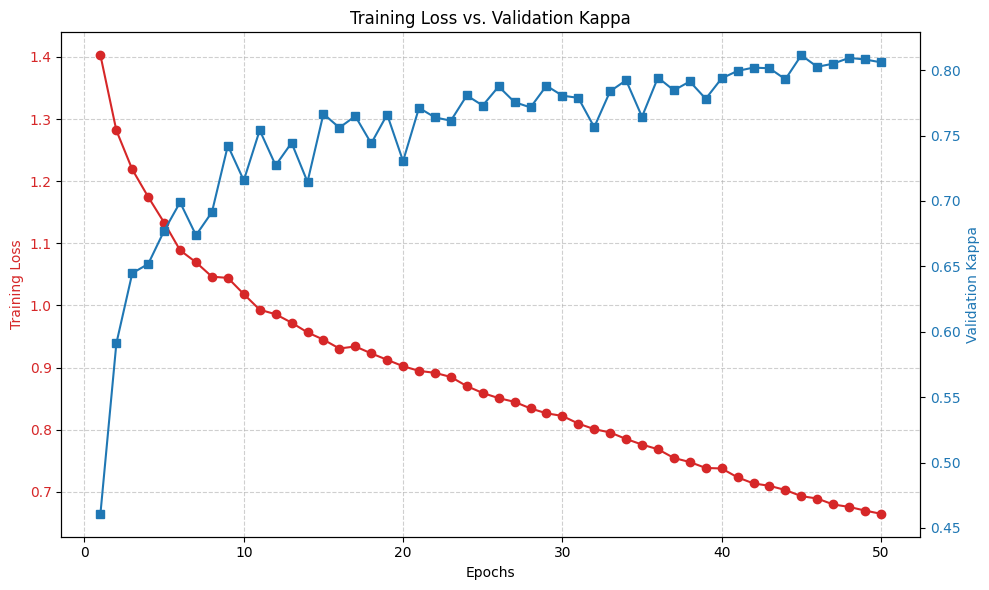

In [8]:
def plot_training_results(history):
    epochs = range(1, len(history) + 1)
    train_loss = [h['train_loss'] for h in history]
    val_kappa = [h['val_kappa'] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss 
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, train_loss, color=color, marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Kappa on the same chart (Secondary Axis) 
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Validation Kappa', color=color)
    ax2.plot(epochs, val_kappa, color=color, marker='s', label='Val Kappa')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss vs. Validation Kappa')
    fig.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_training_results(history)

# Grad Cam

In [9]:
import cv2
import numpy as np

def generate_gradcam(model, img_tensor, label):
    model.eval()
    
    # 1. Hook into the last conv layer
    # For EfficientNet, the last conv layer is usually 'conv_head'
    features = []
    gradients = []

    def save_feature(module, input, output):
        features.append(output)
    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    target_layer = model.layer4[1].conv2 
    
    handle_feat = target_layer.register_forward_hook(save_feature)
    handle_grad = target_layer.register_full_backward_hook(save_gradient)

    # 2. Forward pass
    output = model(img_tensor.to(DEVICE))
    score = output[:, label]
    
    # 3. Backward pass
    model.zero_grad()
    score.backward()

    # 4. Generate Heatmap
    grads = gradients[0].cpu().data.numpy()
    feats = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(2, 3))[0]
    
    cam = np.zeros(feats.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * feats[i]

    # 5. Clean up
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (640, 640))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    handle_feat.remove()
    handle_grad.remove()
    
    return cam

In [10]:
def plot_gradcam(img_path, model, transform):
    # Load and prep image
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0)
    
    # Get prediction
    with torch.no_grad():
        pred = torch.argmax(model(input_tensor.to(DEVICE)), 1).item()
    
    # Generate CAM
    cam = generate_gradcam(model, input_tensor, pred)
    
    # Overlay
    img_np = np.array(img_pil.resize((640, 640)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original (Pred: {pred})")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Focus")
    plt.show()

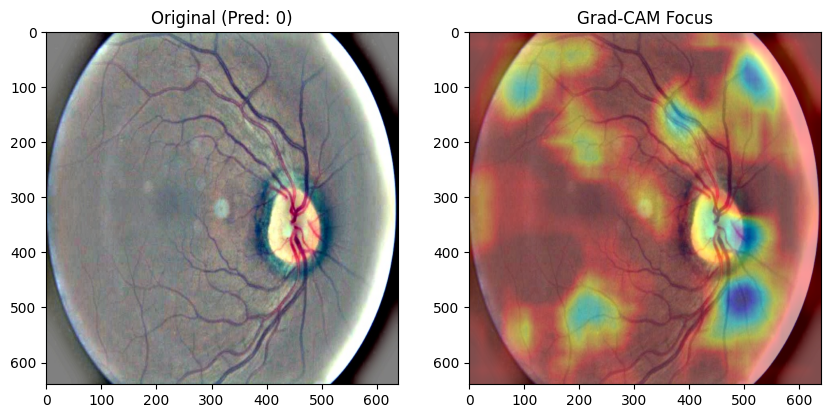

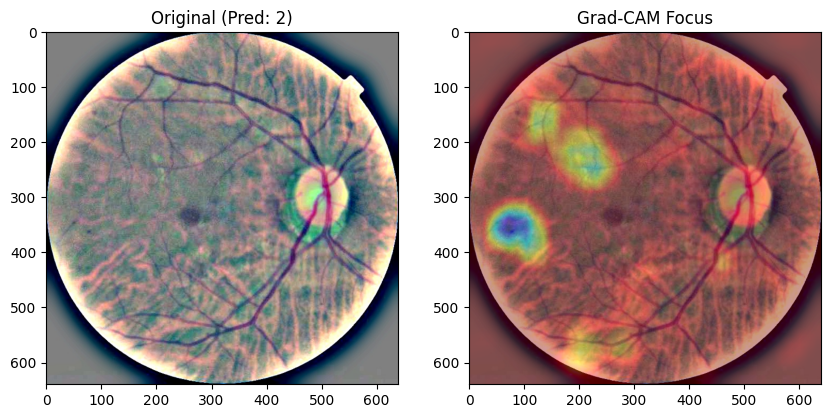

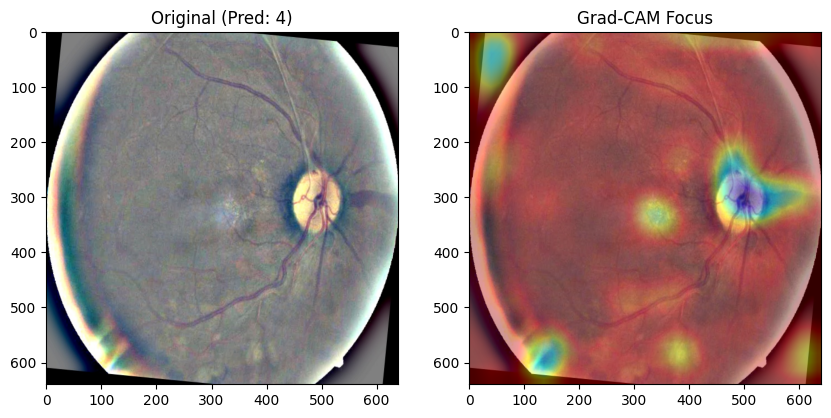

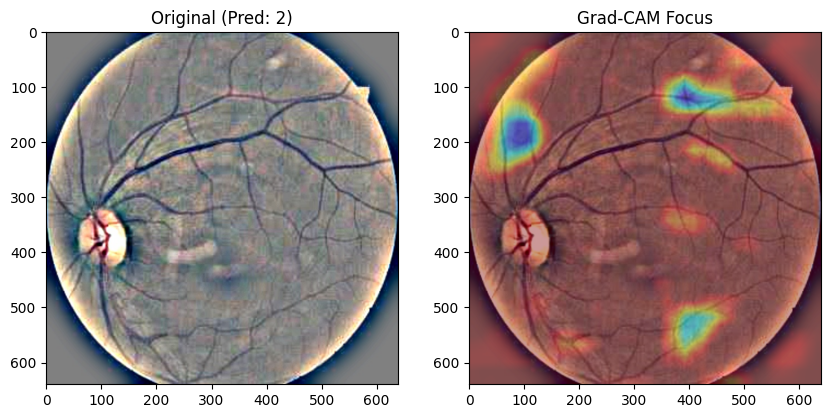

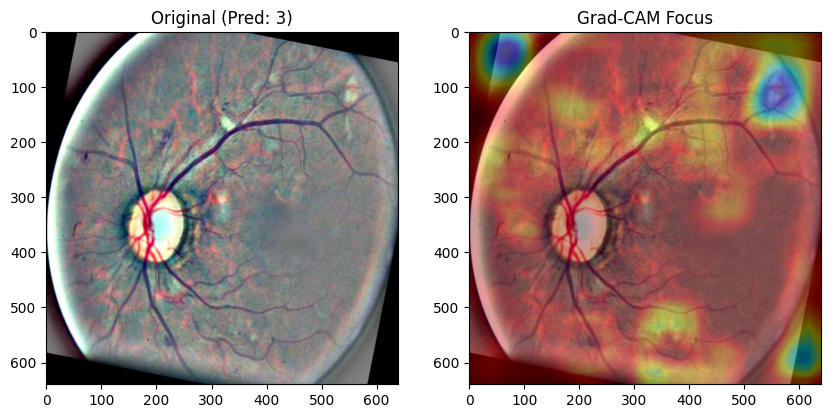

In [11]:
# 1. Load the best weights back into the model
model.load_state_dict(torch.load("custom_model.pth"))

# 2. Pick a few images from the validation set to test
sample_paths = X_test[:5]  # Just the first 5 images for a quick check

for path in sample_paths:
    plot_gradcam(path, model, val_transform)